In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import bomi

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [88]:
import os

all = []
for file in os.listdir("CSVs-completos"):
    df = pd.read_csv(f"CSVs-completos/{file}", index_col=0, parse_dates=["date"], low_memory=False)
    info = bomi.log_info(df)
    bomi.enrich_log(df)
    redesigns = bomi.detect_redesign(df, pd.Timedelta('1D'), threshold_l_events=4)
    info['redesigns'] = redesigns['count'].describe().to_dict()
    info['name'] = file
    all.append(info)

result = pd.DataFrame.from_records(pd.json_normalize(all))


In [89]:
# The first event of the boards. 
result["first_event_type"].value_counts()

createBoard        488
copyBoard           91
createCard          20
copyCommentCard     12
updateCard           3
addMemberToCard      1
commentCard          1
Name: first_event_type, dtype: int64

We will discard all of those that do not start with createBoard. The others might have had problems when they were extracted or they were copied from a previously created board and, in that case, we will be missing information

In [90]:
result_f = result[result["first_event_type"]=="createBoard"]

Now, we analyze the distributions of events, cards and lists to get an idea of how the collection of boards look like

<AxesSubplot:ylabel='events'>

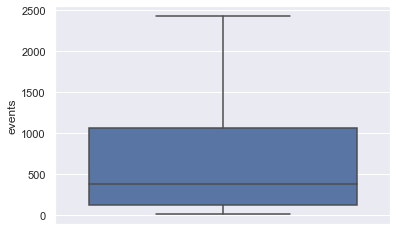

In [107]:
sns.boxplot(y='events', data=result_f, showfliers=False)

<AxesSubplot:ylabel='cards'>

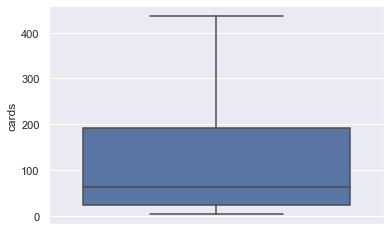

In [108]:
sns.boxplot(y='cards', data=result_f, showfliers=False)

<AxesSubplot:ylabel='lists'>

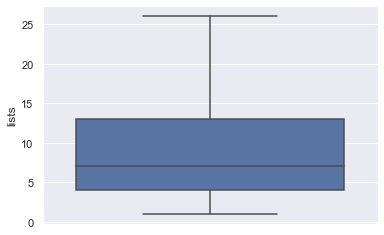

In [109]:
sns.boxplot(y='lists', data=result_f, showfliers=False)

<AxesSubplot:ylabel='redesigns.count'>

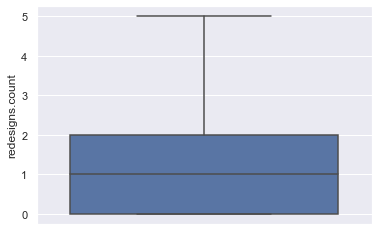

In [100]:
sns.boxplot(y="redesigns.count", data=result_f, showfliers=False)

In [ ]:
result_f[["events", "cards", "lists", "redesigns.count", "redesigns.mean"]].describe()

In [390]:
result_f[["events", "cards", "lists", "redesigns.count", "redesigns.mean", "cards_closed_perc"]].describe()

,events,cards,lists,redesigns.count,redesigns.mean,cards_closed_perc
count,488.000000,488.000000,488.000000,488.000000,361.000000,488.000000
mean,1560.909836,215.127049,12.633197,2.358607,107.520643,0.124358
std,6086.940249,743.618825,35.351603,7.428543,115.182379,0.188189
min,11.000000,4.000000,1.000000,0.000000,7.000000,0.000000
25%,118.500000,24.000000,4.000000,0.000000,40.500000,0.000000
50%,377.000000,63.500000,7.000000,1.000000,68.428571,0.042471
75%,1059.500000,192.250000,13.000000,2.000000,125.000000,0.166667
max,103250.000000,10809.000000,686.000000,121.000000,882.000000,0.928315


What happen if we take only those with more than 1000 events?

In [391]:
result_1000 = result_f[result_f["events"] > 1000]
result_1000[["events", "cards", "lists", "redesigns.count", "redesigns.mean", "cards_moving_perc", "cards_closed_perc"]].describe()

,events,cards,lists,redesigns.count,redesigns.mean,cards_moving_perc,cards_closed_perc
count,129.000000,129.000000,129.000000,129.000000,113.000000,129.000000,129.000000
mean,5070.054264,612.643411,27.472868,5.984496,150.490411,0.376664,0.186591
std,11131.266680,1363.262257,65.998825,13.732935,143.526286,0.313297,0.224634
min,1001.000000,8.000000,1.000000,0.000000,7.500000,0.000000,0.000000
25%,1355.000000,179.000000,9.000000,1.000000,61.333333,0.076455,0.029703
50%,2038.000000,277.000000,15.000000,3.000000,108.000000,0.334928,0.107477
75%,4354.000000,536.000000,23.000000,5.000000,185.529412,0.682692,0.250847
max,103250.000000,10809.000000,686.000000,121.000000,787.500000,0.931894,0.928315


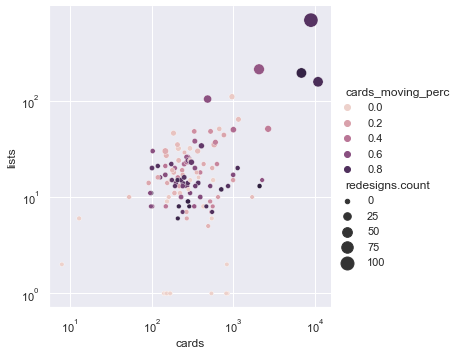

In [382]:
splot = sns.relplot(x="cards", y="lists", size="redesigns.count", sizes=(20,200), hue="cards_moving_perc", data=result_1000)
splot.set(xscale="log", yscale="log")

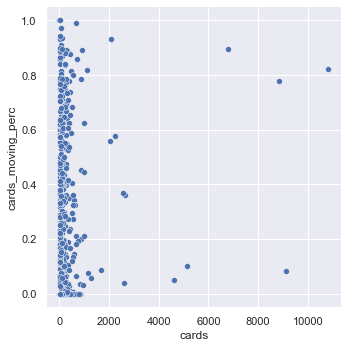

In [389]:
sns.set_theme(style="darkgrid")

sns.relplot(x="cards", y="cards_moving_perc", data=result)

In [184]:
result_1000.query("cards_moving_perc > 0.7")

,events,attribs,cards,lists,list_first_create,list_last_create,list_renamed,list_closed,start,ends,first_event_type,members,card_members_assigned,card_checklists,card_movement,card_closed,card_deleted,card_due,cards_moving_perc,cards_checklist_perc,cards_assigned_perc,cards_closed_perc,name,events_per_member.count,events_per_member.mean,events_per_member.std,events_per_member.min,events_per_member.25%,events_per_member.50%,events_per_member.75%,events_per_member.max,types.createCard,types.updateCard,types.updateBoard,types.addMemberToBoard,types.updateList,types.createList,types.commentCard,types.addMemberToCard,types.createBoard,types.makeAdminOfBoard,types.addAttachmentToCard,redesigns.count,redesigns.mean,redesigns.std,redesigns.min,redesigns.25%,redesigns.50%,redesigns.75%,redesigns.max,types.removeMemberFromCard,types.makeNormalMemberOfBoard,types.deleteAttachmentFromCard,types.addToOrganizationBoard,types.addChecklistToCard,types.deleteCard,types.copyCommentCard,types.copyCard,types.moveListToBoard,types.removeChecklistFromCard,types.unconfirmedBoardInvitation,types.moveCardToBoard,types.moveListFromBoard,types.moveCardFromBoard,types.updateCustomFieldItem,types.updateCheckItemStateOnCard,types.updateCustomField,types.createCustomField,types.deleteCustomField,types.updateChecklist,types.convertToCardFromCheckItem,types.enablePowerUp,types.disablePowerUp,types.emailCard,types.copyBoard,types.removeFromOrganizationBoard,types.makeObserverOfBoard
4,48905,103,8847,686,2020-05-14 00:23:03.192,2022-03-02 05:01:58.050,213,856,2020-05-13 23:55:03.489,2022-03-02 12:14:56.338,createBoard,193,63,10,10026,114,89,11,0.778456,0.000904,0.004973,0.012886,Session Board.csv,193.0,253.393782,616.934112,1.0,12.00,43.0,203.00,4939.0,2560.0,37138.0,24.0,240.0,1728.0,682.0,14.0,63.0,1.0,42.0,7.0,121.0,355.504132,540.158312,12.0,133.00,215.0,357.00,4753.0,52.0,11.0,6.0,NaN,10.0,89.0,1.0,6193.0,NaN,43.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,45447,178,6771,194,2013-09-27 22:45:46.879,2019-03-31 04:17:53.538,219,191,2013-09-27 22:35:21.698,2019-05-03 12:26:09.074,createBoard,38,3276,588,12729,1128,35,337,0.896618,0.062325,0.347216,0.163787,Subnautica Development.csv,38.0,1195.973684,2086.102567,1.0,67.75,449.0,1388.75,9059.0,2596.0,30076.0,29.0,74.0,601.0,169.0,2030.0,3276.0,1.0,1.0,766.0,57.0,144.929825,123.500558,10.0,61.00,120.0,194.00,701.0,818.0,2.0,55.0,1.0,588.0,35.0,28.0,38.0,6.0,29.0,24.0,41.0,56.0,197.0,NaN,3646.0,NaN,NaN,NaN,245.0,8.0,6.0,4.0,1.0,NaN,NaN,NaN
70,3215,90,406,34,2017-09-13 17:58:10.902,2021-11-05 21:46:56.645,66,29,2017-09-13 17:56:11.179,2022-02-12 16:38:40.952,createBoard,31,5,21,951,19,36,47,0.738916,0.044335,0.012315,0.046798,Deisim Development.csv,31.0,103.709677,560.917058,1.0,1.00,3.0,4.00,3126.0,366.0,2327.0,28.0,3.0,138.0,34.0,116.0,5.0,1.0,NaN,1.0,10.0,29.000000,23.142073,5.0,13.75,23.0,36.75,82.0,NaN,NaN,NaN,NaN,21.0,36.0,NaN,2.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,132.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
118,2806,76,240,14,2016-08-17 17:18:55.747,2019-10-09 19:18:15.145,23,7,2016-08-17 17:18:15.917,2021-09-17 22:09:30.189,createBoard,7,7,111,536,55,18,1,0.762500,0.150000,0.008333,0.229167,Resurgence.csv,7.0,400.857143,1042.510980,1.0,1.50,7.0,15.00,2765.0,221.0,1421.0,25.0,5.0,54.0,14.0,9.0,7.0,1.0,NaN,43.0,4.0,213.250000,265.197254,9.0,64.50,122.0,270.75,600.0,6.0,NaN,6.0,NaN,111.0,18.0,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,838.0,NaN,NaN,NaN,17.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
127,1234,70,209,6,2020-02-01 14:01:38.607,2020-02-01 14:05:30.995,0,0,2020-02-01 14:01:28.465,2022-01-28 11:51:21.145,createBoard,2,4,5,504,13,1,0,0.880383,0.023923,0.019139,0.062201,GTFO_VR.csv,2.0,617.000000,868.327127,3.0,310.00,617.0,924.00,1231.0,208.0,960.0,13.0,NaN,1.0,6.0,11.0,4.0,1.0,NaN,NaN,1.0,43.000000,NaN,43.0,43.00,43.0,43.00,43.0,2.0,NaN,NaN,NaN,5.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138,2762,72,371,14,2019-09-01 00:15:12.620,2020-12-02 05:0

In [185]:
result[result["name"]=="GMod Tower.csv"]

,events,attribs,cards,lists,list_first_create,list_last_create,list_renamed,list_closed,start,ends,first_event_type,members,card_members_assigned,card_checklists,card_movement,card_closed,card_deleted,card_due,cards_moving_perc,cards_checklist_perc,cards_assigned_perc,cards_closed_perc,name,events_per_member.count,events_per_member.mean,events_per_member.std,events_per_member.min,events_per_member.25%,events_per_member.50%,events_per_member.75%,events_per_member.max,types.createCard,types.updateCard,types.updateBoard,types.addMemberToBoard,types.updateList,types.createList,types.commentCard,types.addMemberToCard,types.createBoard,types.makeAdminOfBoard,types.addAttachmentToCard,redesigns.count,redesigns.mean,redesigns.std,redesigns.min,redesigns.25%,redesigns.50%,redesigns.75%,redesigns.max,types.removeMemberFromCard,types.makeNormalMemberOfBoard,types.deleteAttachmentFromCard,types.addToOrganizationBoard,types.addChecklistToCard,types.deleteCard,types.copyCommentCard,types.copyCard,types.moveListToBoard,types.removeChecklistFromCard,types.unconfirmedBoardInvitation,types.moveCardToBoard,types.moveListFromBoard,types.moveCardFromBoard,types.updateCustomFieldItem,types.updateCheckItemStateOnCard,types.updateCustomField,types.createCustomField,types.deleteCustomField,types.updateChecklist,types.convertToCardFromCheckItem,types.enablePowerUp,types.disablePowerUp,types.emailCard,types.copyBoard,types.removeFromOrganizationBoard,types.makeObserverOfBoard
377,14108,192,2085,13,2013-10-16 14:47:17.141,2020-01-10 15:34:25.919,11,10,2013-10-16 14:23:00.772,2022-01-30 19:08:26.549,createBoard,24,1113,67,3922,1885,7,3,0.931894,0.031175,0.507914,0.902158,Territory Helper.csv,24.0,587.833333,2795.804087,1.0,1.0,2.5,9.5,13711.0,2074.0,10024.0,67.0,5.0,37.0,10.0,225.0,1113.0,1.0,9.0,4.0,3.0,91.666667,107.908912,10.0,30.5,51.0,132.5,214.0,30.0,1.0,1.0,NaN,67.0,7.0,NaN,NaN,NaN,4.0,11.0,NaN,1.0,NaN,NaN,406.0,NaN,NaN,NaN,6.0,NaN,3.0,2.0,NaN,NaN,NaN,NaN


In [429]:
result[(result['cards_moving_perc'] < 0.25) & (result['events'] > 500)]

,events,attribs,cards,lists,list_first_create,list_last_create,list_renamed,list_closed,start,ends,first_event_type,members,card_members_assigned,card_checklists,card_movement,card_closed,card_deleted,card_due,cards_moving_perc,cards_checklist_perc,cards_assigned_perc,cards_closed_perc,name,events_per_member.count,events_per_member.mean,events_per_member.std,events_per_member.min,events_per_member.25%,events_per_member.50%,events_per_member.75%,events_per_member.max,types.createCard,types.updateCard,types.updateBoard,types.addMemberToBoard,types.createList,types.updateList,types.commentCard,types.addAttachmentToCard,types.makeAdminOfBoard,types.createBoard,types.addMemberToCard,types.removeMemberFromCard,types.makeNormalMemberOfBoard,types.addToOrganizationBoard,types.addChecklistToCard,types.deleteCard,types.deleteAttachmentFromCard,types.copyCommentCard,types.copyCard,types.moveListToBoard,types.removeChecklistFromCard,types.unconfirmedBoardInvitation,types.moveCardToBoard,types.moveListFromBoard,types.moveCardFromBoard,types.updateCustomFieldItem,types.updateCheckItemStateOnCard,types.updateCustomField,types.createCustomField,types.deleteCustomField,types.updateChecklist,types.convertToCardFromCheckItem,types.enablePowerUp,types.disablePowerUp,types.emailCard,types.copyBoard,types.removeFromOrganizationBoard,types.makeObserverOfBoard
16,8384,112,1151,64,2019-04-06 01:40:53.515,2019-09-16 05:01:03.536,34,14,2019-04-06 01:40:10.511,2021-07-09 19:50:58.105,createBoard,16,69,52,117,44,112,0,0.076455,0.044309,0.026064,0.037359,Rogue Lineage.csv,16.0,524.000000,852.258020,39.0,110.50,268.5,382.75,3289.0,383.0,4638.0,25.0,17.0,61.0,85.0,40.0,658.0,4.0,1.0,69.0,63.0,4.0,NaN,52.0,112.0,239.0,4.0,655.0,1.0,2.0,NaN,NaN,33.0,1.0,1028.0,187.0,10.0,9.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,1098,73,202,15,2021-08-09 01:18:45.230,2021-08-09 01:18:45.230,2,0,2021-06-17 01:45:03.708,2022-02-02 04:06:21.548,copyBoard,6,0,0,21,17,1,0,0.084158,0.000000,0.000000,0.084158,JJBU trello.csv,6.0,183.000000,424.842088,1.0,4.00,8.5,22.75,1050.0,37.0,989.0,3.0,6.0,1.0,2.0,1.0,45.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
23,2033,79,212,32,2020-08-16 17:23:11.472,2022-02-04 18:34:38.213,18,13,2020-08-16 17:21:28.616,2022-02-04 21:17:23.573,createBoard,8,1,0,9,26,3,0,0.033019,0.000000,0.004717,0.122642,Tatakai.csv,8.0,254.125000,396.627006,6.0,9.00,27.0,376.00,1119.0,208.0,1149.0,22.0,9.0,32.0,80.0,NaN,447.0,2.0,1.0,1.0,1.0,1.0,NaN,NaN,3.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,620,65,123,19,2019-02-09 09:10:38.861,2020-05-10 06:36:16.482,15,1,2019-02-09 09:10:29.508,2020-10-30 09:30:34.993,createBoard,1,3,0,29,1,0,0,0.195122,0.000000,0.016260,0.008130,托福口语.csv,1.0,620.000000,NaN,620.0,620.00,620.0,620.00,620.0,122.0,355.0,4.0,NaN,19.0,34.0,72.0,2.0,NaN,1.0,3.0,3.0,NaN,NaN,NaN,NaN,1.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,2875,74,236,19,2020-12-08 23:31:19.639,2021-01-21 23:05:25.337,32,6,2020-12-08 23:29:04.431,2021-08-16 18:22:24.155,createBoard,5,6,0,108,6,29,0,0.245763,0.000000,0.021186,0.025424,a.csv,5.0,575.000000,761.928802,13.0,144.00,200.0,649.00,1869.0,206.0,2138.0,3.0,4.0,16.0,48.0,NaN,352.0,NaN,1.0,6.0,3.0,NaN,NaN,NaN,29.0,68.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,737,31,95,1,2021-06-20 04:06:52.909,2021-06-20 04:06:52.909,0,0,2021-06-20 04:06:34.887,2021-07-02 09:43:28.979,createBoard,1,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,exnolume.csv,1.0,737.000000,NaN,737.0,737.00,737.0,737.00,737.0,95.0,87.0,1.0,NaN,1.0,NaN,463.0,89.0,NaN,1

# List analysis

In [392]:
df = pd.read_csv(f"CSVs-completos/Wayward Todo.csv", index_col=0, parse_dates=["date"], low_memory=False)
bomi.enrich_log(df)

In [360]:
df.tail()

,id,idMemberCreator,appCreator,type,date,data.board.shortLink,data.board.name,data.board.id,data.value,data.idMember,member.id,member.activityBlocked,member.avatarHash,member.avatarUrl,member.fullName,member.idMemberReferrer,member.initials,member.nonPublicAvailable,member.username,data.board.prefs.selfJoin,data.old.prefs.selfJoin,data.board.prefs.comments,data.old.prefs.comments,data.list.name,data.list.id,data.card.shortLink,data.card.idShort,data.card.name,data.card.id,data.text,limits.reactions.perAction.status,limits.reactions.perAction.disableAt,limits.reactions.perAction.warnAt,limits.reactions.uniquePerAction.status,limits.reactions.uniquePerAction.disableAt,limits.reactions.uniquePerAction.warnAt,data.board.prefs.cardAging,data.old.prefs.cardAging,data.board.prefs.voting,data.old.prefs.voting,data.board.prefs.background,data.old.prefs.background,data.list.pos,data.old.pos,data.card.idAttachmentCover,data.old.idAttachmentCover,data.attachment.previewUrl2x,data.attachment.previewUrl,data.attachment.url,data.attachment.name,data.attachment.id,data.card.desc,data.old.desc,data.old.due,data.card.due,data.old.name,data.card.closed,data.old.closed,data.listAfter.name,data.listAfter.id,data.listBefore.name,data.listBefore.id,data.card.idList,data.old.idList,data.card.pos,data.deactivated,data.dateLastEdited,data.checklist.name,data.checklist.id,data.checkItem.state,data.checkItem.name,data.checkItem.id,data.embedly,data.textData.emoji.awesomeface_colored,data.textData.emoji.sapphire,data.textData.emoji.ultimate_chimera,data.textData.emoji.murrwanna,data.checkItem.textData,data.textData.emoji.gmt,data.member.name,data.member.id,data.boardSource.id,data.boardTarget.id,data.cardSource.shortLink,data.cardSource.idShort,data.cardSource.name,data.cardSource.id,data.idOriginalCommenter,data.idMemberAdded,data.memberType,data.list.pos.updatedLists,data.board.prefs.invitations,data.old.prefs.invitations,data.checklist.idCard.updateTargetBadges,data.checklist.idCard.boardTarget._id,data.checklist.idCard.boardTarget.checklists,data.checklist.idCard.boardTarget.closed,data.checklist.idCard.boardTarget.deleted,data.checklist.idCard.boardTarget.desc,data.checklist.idCard.boardTarget.idMembersRemoved,data.checklist.idCard.boardTarget.idMembersWatching,data.checklist.idCard.boardTarget.idOrganization,data.checklist.idCard.boardTarget.idShortNext,data.checklist.idCard.boardTarget.invitations,data.checklist.idCard.boardTarget.lists,data.checklist.idCard.boardTarget.memberships,data.checklist.idCard.boardTarget.name,data.checklist.idCard.boardTarget.shortLink,data.checklist.idCard.boardTarget.labelNames.blue,data.checklist.idCard.boardTarget.labelNames.green,data.checklist.idCard.boardTarget.labelNames.orange,data.checklist.idCard.boardTarget.labelNames.purple,data.checklist.idCard.boardTarget.labelNames.red,data.checklist.idCard.boardTarget.labelNames.yellow,data.checklist.idCard.boardTarget.prefs.comments,data.checklist.idCard.boardTarget.prefs.invitations,data.checklist.idCard.boardTarget.prefs.permissionLevel,data.checklist.idCard.boardTarget.prefs.selfJoin,data.checklist.idCard.boardTarget.prefs.voting,data.checklist.idCard.cardTarget._id,data.checklist.idCard.cardTarget.attachments,data.checklist.idCard.cardTarget.checkItemStates,data.checklist.idCard.cardTarget.closed,data.checklist.idCard.cardTarget.dateLastActivity,data.checklist.idCard.cardTarget.deleted,data.checklist.idCard.cardTarget.desc,data.checklist.idCard.cardTarget.idBoard,data.checklist.idCard.cardTarget.idChecklists,data.checklist.idCard.cardTarget.idList,data.checklist.idCard.cardTarget.idMembers,data.checklist.idCard.cardTarget.idMembersVoted,data.checklist.idCard.cardTarget.idShort,data.checklist.idCard.cardTarget.labels,data.checklist.idCard.cardTarget.manualCoverAttachment,data.checklist.idCard.cardTarget.name,data.checklist.idCard.cardTarget.pos,data.checklist.idCard.cardTarget.shortLink,data.checklist.idCard.cardTarget.warnWhenUpcoming,data.checklist.idCard.cardTarge

In [394]:
bomi.list_renames(df)

data.list.id
53164fec2e3c1e741072f390    [Working On (1.9x+), Working On (1.9+), Workin...
53164fec2e3c1e741072f391                       [Working On (1.8), Working On]
53164fec2e3c1e741072f392                                     [2.0 Done, Done]
531c46531663227c61bd1ef8    [To Do (Road to 2.0), To Do, Master To Do, To ...
531d454282418cab4e898079              [Can't Replicate Bugs, Unresolved Bugs]
531f2f0141ef12ca4e8aaa90                                               [News]
5324cfb5e3536cb6520f577f    [1.1+ Future Ideas, 3.1+ Future Ideas, 3.0+ Fu...
5324d377e132cf0473e55706                                     [User Submitted]
5324d7659e8fdc211e0be66c    [User Submitted (Unsorted), User Submitted/Uns...
5330465dbfff92a24ff20c96                                     [User Submitted]
533c17c0236386992987ca9f    [2.0 Todo/Bugs, 2.0 Todo (Early Access), 2.0 (...
549f70dc36671034dd622449                                  [2.0 Non-game Todo]
54a0acf433133f2add459a71    [Working On/Doing, Work

In [371]:
df['c'].value_counts()

card_act       4052
card_move       500
card_create     229
card_close       31
card_delete      19
Name: c, dtype: int64

In [372]:
begin_end_redesign = bomi.detect_redesign(df, pd.Timedelta('1D'), threshold_l_events=5)
begin_end_redesign

,min,max,count,count_l_events
5,2020-07-23 13:28:11.155000+00:00,2020-07-24 12:45:39.539000+00:00,166,11
15,2018-12-28 01:37:20.582000+00:00,2018-12-28 02:36:27.704000+00:00,68,14


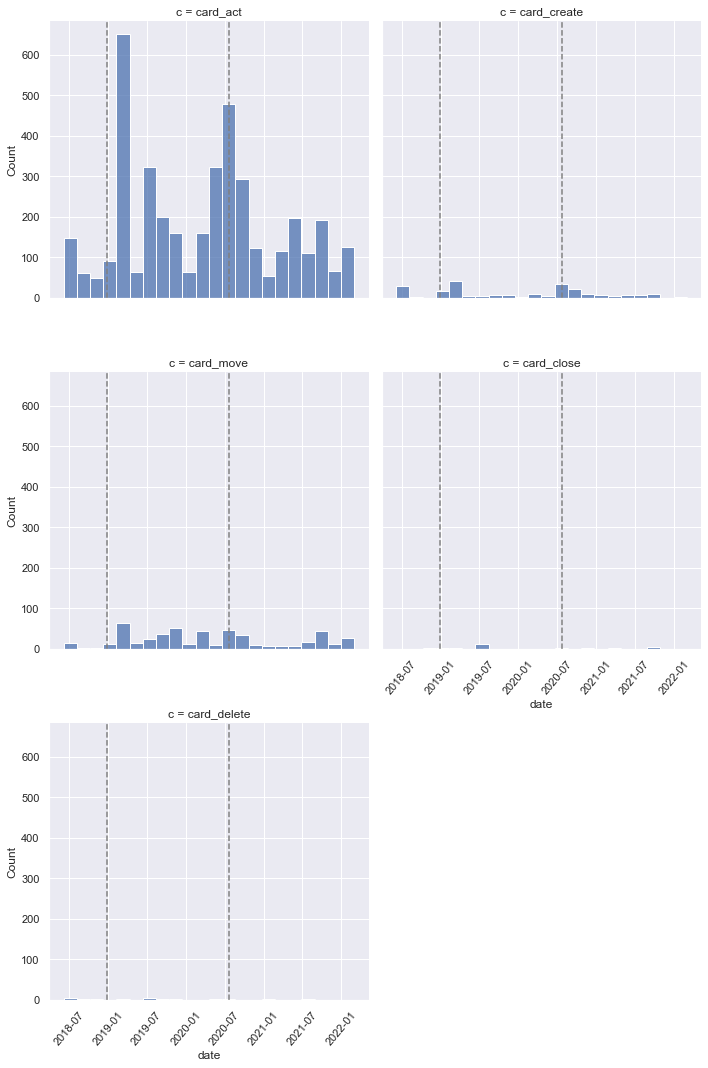

In [373]:
import seaborn as sns

ax = sns.displot(df, x="date", col="c", col_wrap=2)
ax.set_xticklabels(rotation=50)

for f in begin_end_redesign["min"].values:
    ax.refline(x=f)

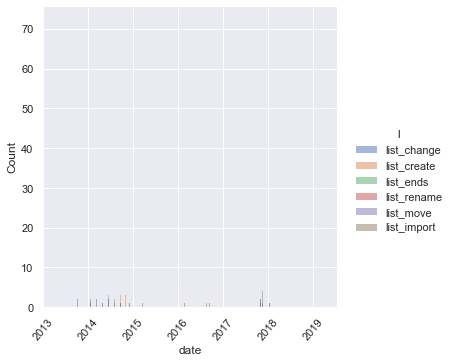

In [340]:
chart = sns.displot(df, hue="l", x="date", binwidth=1)
chart.set_xticklabels(rotation=50)

In [374]:
filtered_result = bomi.list_evolution(df, filter_short_lists=pd.Timedelta('30m'))
filtered_result.head(50)


,begin_date,last_date,last_name,data.list.name
data.list.id,,,,
5afdeea90d402a16904fdfd2,2018-05-17 21:05:45.562000+00:00,2018-06-05 15:00:46.774000+00:00,Esperando,[Esperando]
5b16a52ac319979629f46fd1,2018-06-05 14:58:50.870000+00:00,2019-02-28 21:34:21.843000+00:00,Rejeitadas - Canceladas | Rejected - Canceled,[Rejeitadas - Canceladas | Rejected - Canceled...
5c8857105382124627b4a66b,2019-03-13 01:04:16.940000+00:00,2019-03-18 15:45:21.480000+00:00,Implementado nos servidores(nesse ou no proxim...,[Implementado nos servidores(nesse ou no proxi...
5c9191914504ce4ec37d07f3,2019-03-20 01:04:17.754000+00:00,2019-04-01 18:47:24.411000+00:00,Implementado nos servidores (nesse ou no proxi...,[Implementado nos servidores (nesse ou no prox...
5afdee8da1b99d0365223938,2018-05-17 21:05:17.987000+00:00,2019-08-10 03:17:35.542000+00:00,Info,"[Info, Informações]"
5d768422ca52ca357591a6f9,2019-09-09 16:56:02.058000+00:00,2020-07-23 13:29:02.655000+00:00,Bugs,[Bugs]
5b1c0c5b59d25ab5ae6fb4fc,2018-06-09 17:20:27.701000+00:00,2020-07-23 13:31:16.588000+00:00,Propostas | Proposals,"[Propostas | Proposals, Proposals, Rookgaard -..."
5d659f543c29948a0ca814e4,2019-08-27 21:23:32.943000+00:00,2020-07-23 13:31:20.229000+00:00,Testes e revisões,[Testes e revisões]
5afdeeaee694682aa812f654,2018-05-17 21:05:50.707000+00:00,2020-07-23 13:31:22.082000+00:00,Concluído | Done,"[Concluído | Done, Pronto | Done, Done, Pronto]"


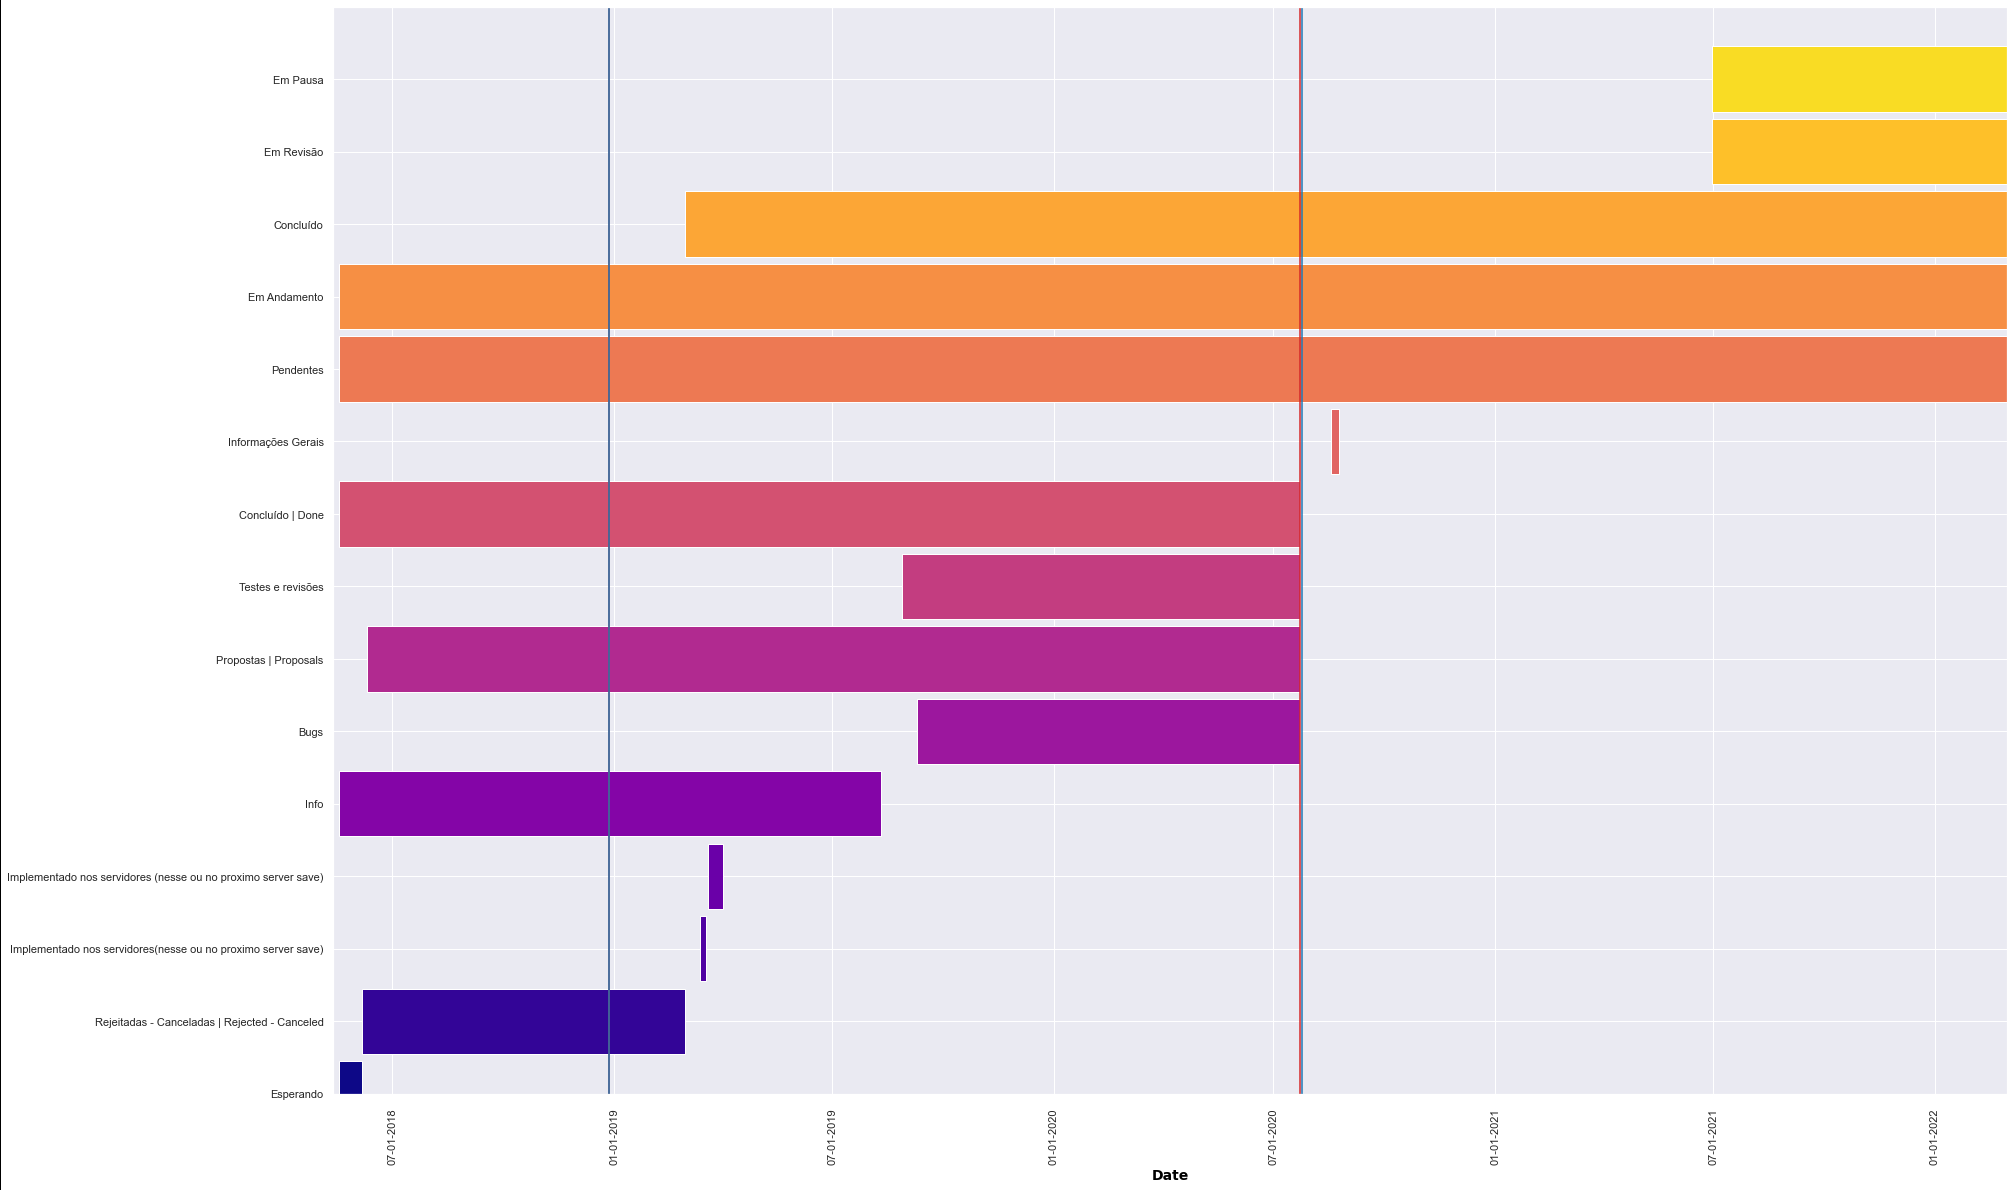

In [375]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(30, 20), edgecolor="black", linewidth=1)

bomi.plot_list_diagram(filtered_result, begin_end_redesign, ax)

plt.show()


# Lists analysis

In [ ]:
sns.displot(df[df["c"].isin(["card_create", "card_close", "card_delete"])], x="date", hue="c", col="data.list.name", col_wrap=4, kind='hist')

In [ ]:
df.loc[df["type"]=="createCard", "h"] = "create"
df.loc[df["type"].isin(["updateCard", "addMemberToCard", "commentCard", "addChecklistToCard", "updateCheckItemStateOnCard", "removeMemberFromCard", "deleteCard", "updateChecklist", "removeChecklistFromCard", "addAttachmentToCard", "deleteAttachmentFromCard"]), "h"] = "action"
df["date"] = pd.to_datetime(df["date"])
first = df[(df["date"].dt.date < pd.Timestamp(2021,1,30)) ]
sns.displot(first[first["c"].isin(["card_act", "card_create"])], x="date", hue="c", binwidth=1, col_wrap=3, col="data.list.name", kind='hist', height=30)

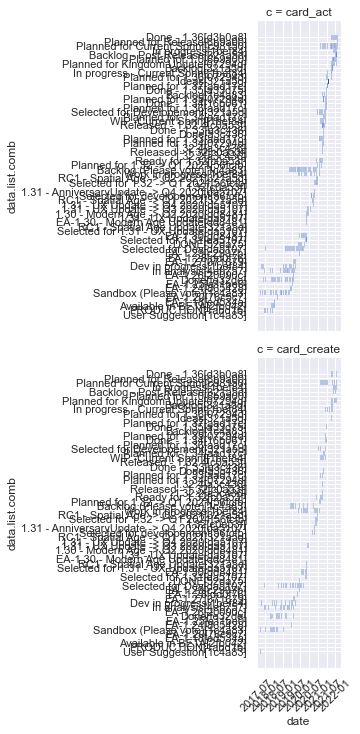

In [355]:
bomi.plot_card_actions(df)

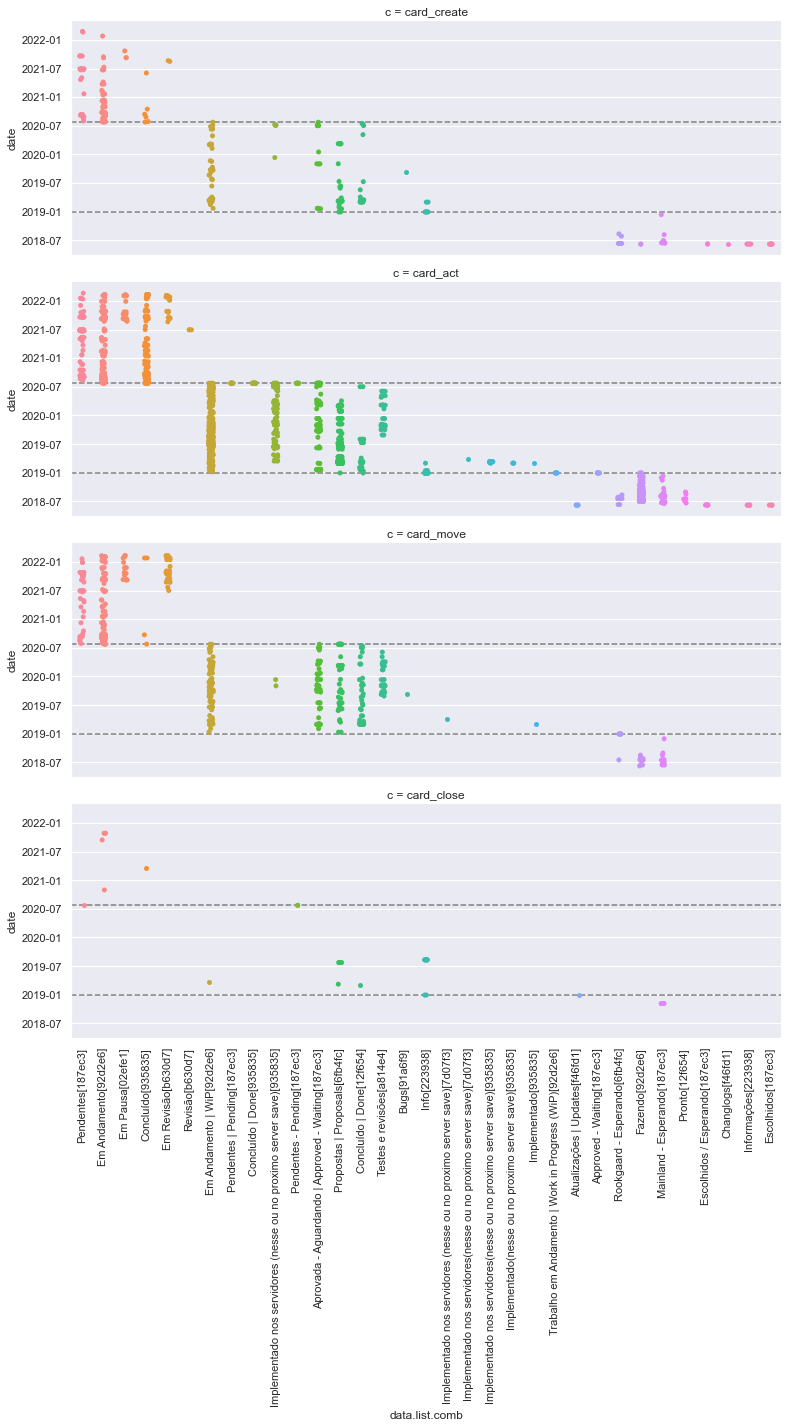

In [378]:
ch = sns.catplot(x="data.list.comb", y="date", row="c", row_order=["card_create", "card_act", "card_move", "card_close"], data=df[df["c"].isin(["card_act", "card_create", "card_move", "card_close"])], aspect=20/9)
ch.set_xticklabels(rotation=90)

for f in begin_end_redesign["min"].values:
    ch.refline(y=f)



# Transitions analysis

In [379]:
bomi.transition_matrix(df)

data.listAfter.name,Approved - Waiting,Aprovada - Aguardando | Approved - Waiting,Concluído,Concluído | Done,Em Andamento,Em Andamento | WiP,Em Pausa,Em Revisão,Fazendo,Implementado,Implementado nos servidores (nesse ou no proximo server save),Implementado nos servidores(nesse ou no proximo server save),Implementado(nesse ou no proximo server save),Mainland - Esperando,Pendentes,Pronto,Propostas | Proposals,Revisão,Testes e revisões
data.listBefore.name,,,,,,,,,,,,,,,,,,,
Aprovada - Aguardando | Approved - Waiting,NaN,NaN,NaN,2.0,NaN,31.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,22.0,NaN,1.0
Bugs,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Concluído,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Concluído | Done,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,15.0,28.0,9.0,3.0,NaN,NaN,NaN,NaN,NaN,1.0
Em Andamento,NaN,NaN,55.0,NaN,NaN,NaN,9.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,1.0,NaN
Em Andamento | WiP,NaN,19.0,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,28.0
Em Pausa,NaN,NaN,NaN,NaN,14.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Em Revisão,NaN,NaN,20.0,NaN,2.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fazendo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,6.0,NaN,NaN,NaN


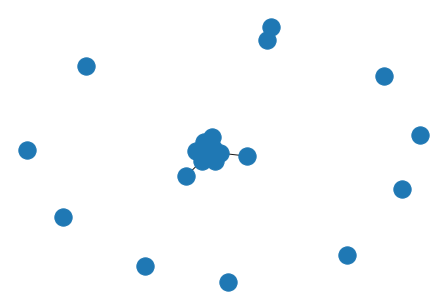

In [226]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from(df['data.list.comb'].dropna())
G.add_edges_from(df[['data.listAfter.comb','data.listBefore.comb']].dropna().to_numpy().tolist())

nx.draw(G)

In [380]:
bomi.connected_lists(df, use='comb')

[{'Concluído[935835]',
  'Em Andamento[92d2e6]',
  'Em Pausa[02efe1]',
  'Em Revisão[b630d7]',
  'Pendentes[187ec3]',
  'Revisão[b630d7]'},
 {'Informações Gerais[228a52]'},
 {'Revisão e Testes[a0bcae]'},
 {'Aprovada - Aguardando | Approved - Waiting[187ec3]',
  'Bugs[91a6f9]',
  'Concluído | Done[12f654]',
  'Em Andamento | WiP[92d2e6]',
  'Implementado nos servidores (nesse ou no proximo server save)[7d07f3]',
  'Implementado nos servidores (nesse ou no proximo server save)[935835]',
  'Implementado nos servidores(nesse ou no proximo server save)[7d07f3]',
  'Implementado nos servidores(nesse ou no proximo server save)[935835]',
  'Implementado(nesse ou no proximo server save)[935835]',
  'Implementado[935835]',
  'Propostas | Proposals[6fb4fc]',
  'Testes e revisões[a814e4]'},
 {'Pendentes | Pending[187ec3]'},
 {'Concluído | Done[935835]'},
 {'Pendentes - Pending[187ec3]'},
 {'Info[223938]'},
 {'Implementado nos servidores(nesse ou no proximo server save)[b4a66b]'},
 {'Rejeitadas - C

<AxesSubplot:xlabel='data.listAfter.name', ylabel='data.listBefore.name'>

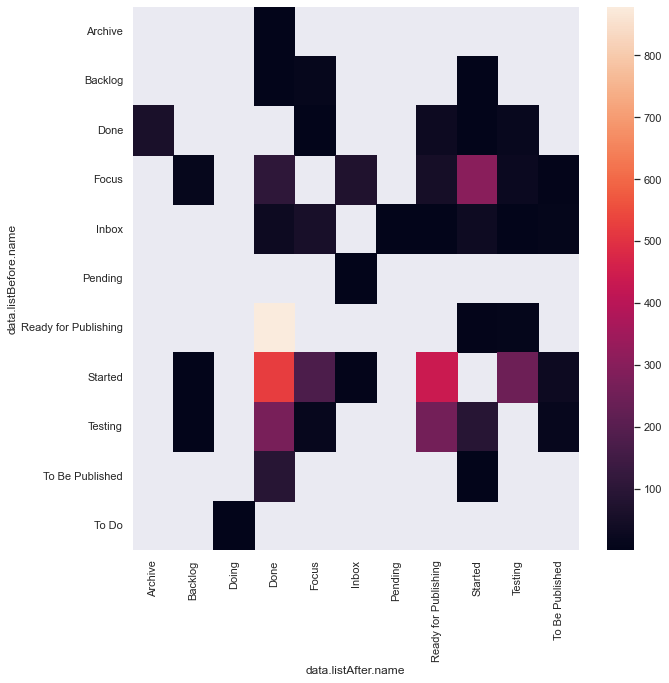

In [225]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.groupby(['data.listBefore.name', 'data.listAfter.name'])['id'].count().unstack(), xticklabels=True, yticklabels=True, ax=ax)

# Conversion to event log

In [274]:
import pm4py

evlog = bomi.to_event_log(df)


In [275]:
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
xes_exporter.apply(evlog, 'log.xes')

exporting log, completed traces :: 100%|██████████| 1124/1124 [00:00<00:00, 4802.56it/s]


In [276]:
from pm4py.statistics.traces.generic.log import case_statistics
case_statistics.get_variant_statistics(evlog)

[{'variant': 'Doing,Recently Done/Fixed,**Closed', 'count': 251},
 {'variant': 'Reported Bugs,Recently Done/Fixed,**Closed', 'count': 134},
 {'variant': 'Reported Bugs,Doing,Recently Done/Fixed,**Closed', 'count': 70},
 {'variant': 'Reported Bugs,**Closed', 'count': 41},
 {'variant': 'Doing,**Closed', 'count': 29},
 {'variant': 'To Do (post-launch),**Closed', 'count': 27},
 {'variant': 'Doing,Done/Fixed,**Closed', 'count': 25},
 {'variant': 'Doing,Done,**Closed', 'count': 18},
 {'variant': 'Reported Bugs,Doing,Done/Fixed,**Closed', 'count': 16},
 {'variant': 'Reported Bugs/Suggestions,Recently Done/Fixed,**Closed',
  'count': 15},
 {'variant': 'Doing,Recently Done/Fixed,Recently Done/Fixed,**Closed',
  'count': 14},
 {'variant': 'To Do/Future Ideas,**Closed', 'count': 12},
 {'variant': 'Doing,Recently Done/Fixed', 'count': 12},
 {'variant': 'To Do/Future Ideas', 'count': 10},
 {'variant': 'To Do (post-launch),Doing,Recently Done/Fixed,**Closed',
  'count': 10},
 {'variant': 'Reported B

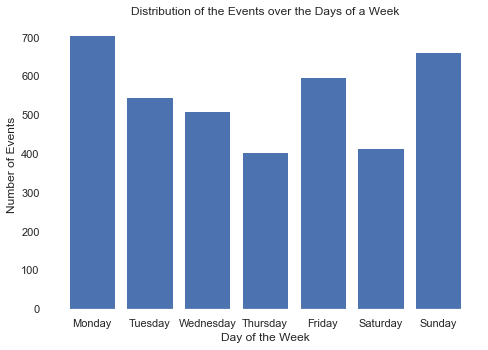

In [277]:
pm4py.view_events_distribution_graph(evlog, distr_type="days_week", format="png")


In [292]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.algo.filtering.log.timestamp import timestamp_filter

filtered_log = variants_filter.filter_log_variants_percentage(evlog, percentage=1)
#filtered_log = timestamp_filter.filter_traces_intersecting(filtered_log, "2014-09-20 00:00:00", "2022-01-18 23:59:59")


In [293]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
dfg = dfg_discovery.apply(filtered_log)

dfg

Counter({('Doing', 'Recently Done/Fixed'): 504,
         ('Recently Done/Fixed', '**Closed'): 650,
         ('Reported Bugs', 'Recently Done/Fixed'): 172,
         ('Reported Bugs', 'Doing'): 182,
         ('Reported Bugs', '**Closed'): 64,
         ('Doing', '**Closed'): 48,
         ('To Do (post-launch)', '**Closed'): 46,
         ('Doing', 'Done/Fixed'): 52,
         ('Done/Fixed', '**Closed'): 52,
         ('Doing', 'Done'): 34,
         ('Done', '**Closed'): 36,
         ('Reported Bugs/Suggestions', 'Recently Done/Fixed'): 19,
         ('Recently Done/Fixed', 'Recently Done/Fixed'): 16,
         ('To Do/Future Ideas', '**Closed'): 27,
         ('To Do (post-launch)', 'Doing'): 57,
         ('Doing', 'Reported Bugs'): 79,
         ('Doing', 'To Do/Future Ideas'): 44,
         ('To Do', 'Future To Do'): 21,
         ('Future To Do', '**Closed'): 12,
         ('To Do/Future Ideas', 'Future Goals for Lobby 2'): 17,
         ('To Do', 'Upcoming Maps/Gamemodes'): 10,
         ('Future

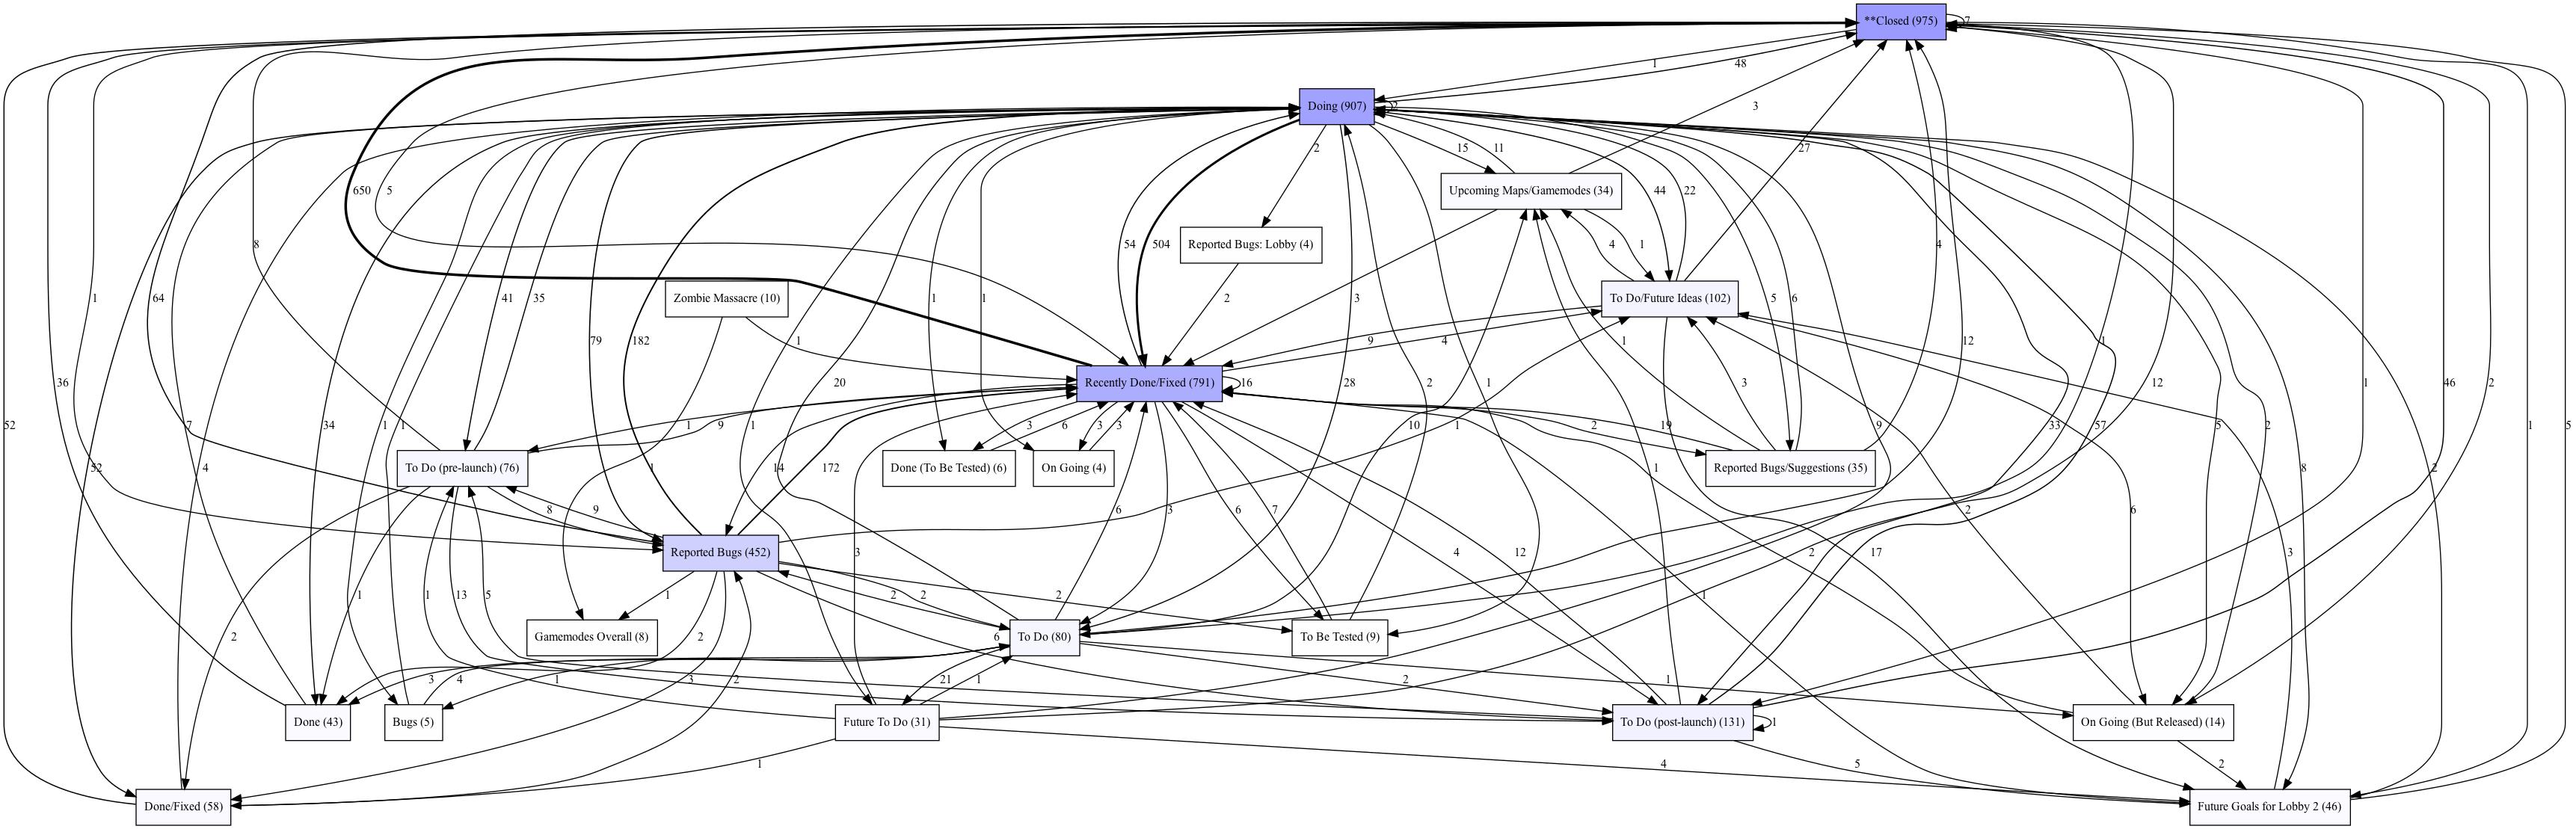

In [294]:
from pm4py.visualization.dfg import visualizer as dfg_visualization
gviz = dfg_visualization.apply(dfg, log=filtered_log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

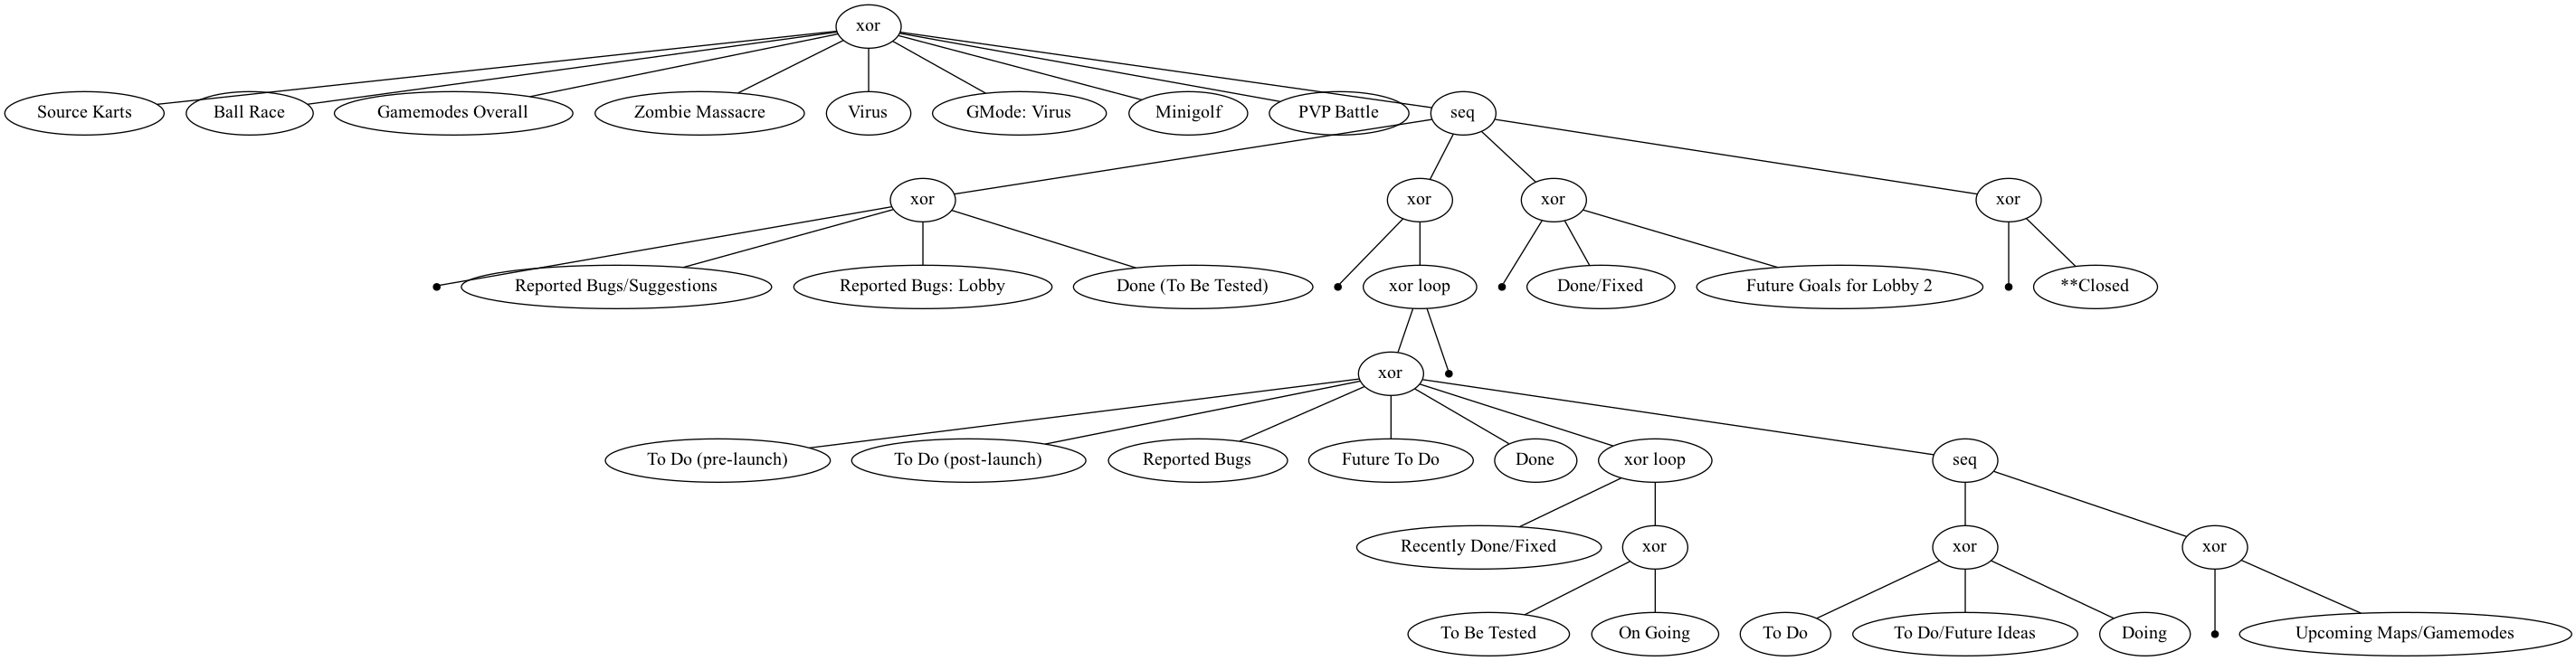

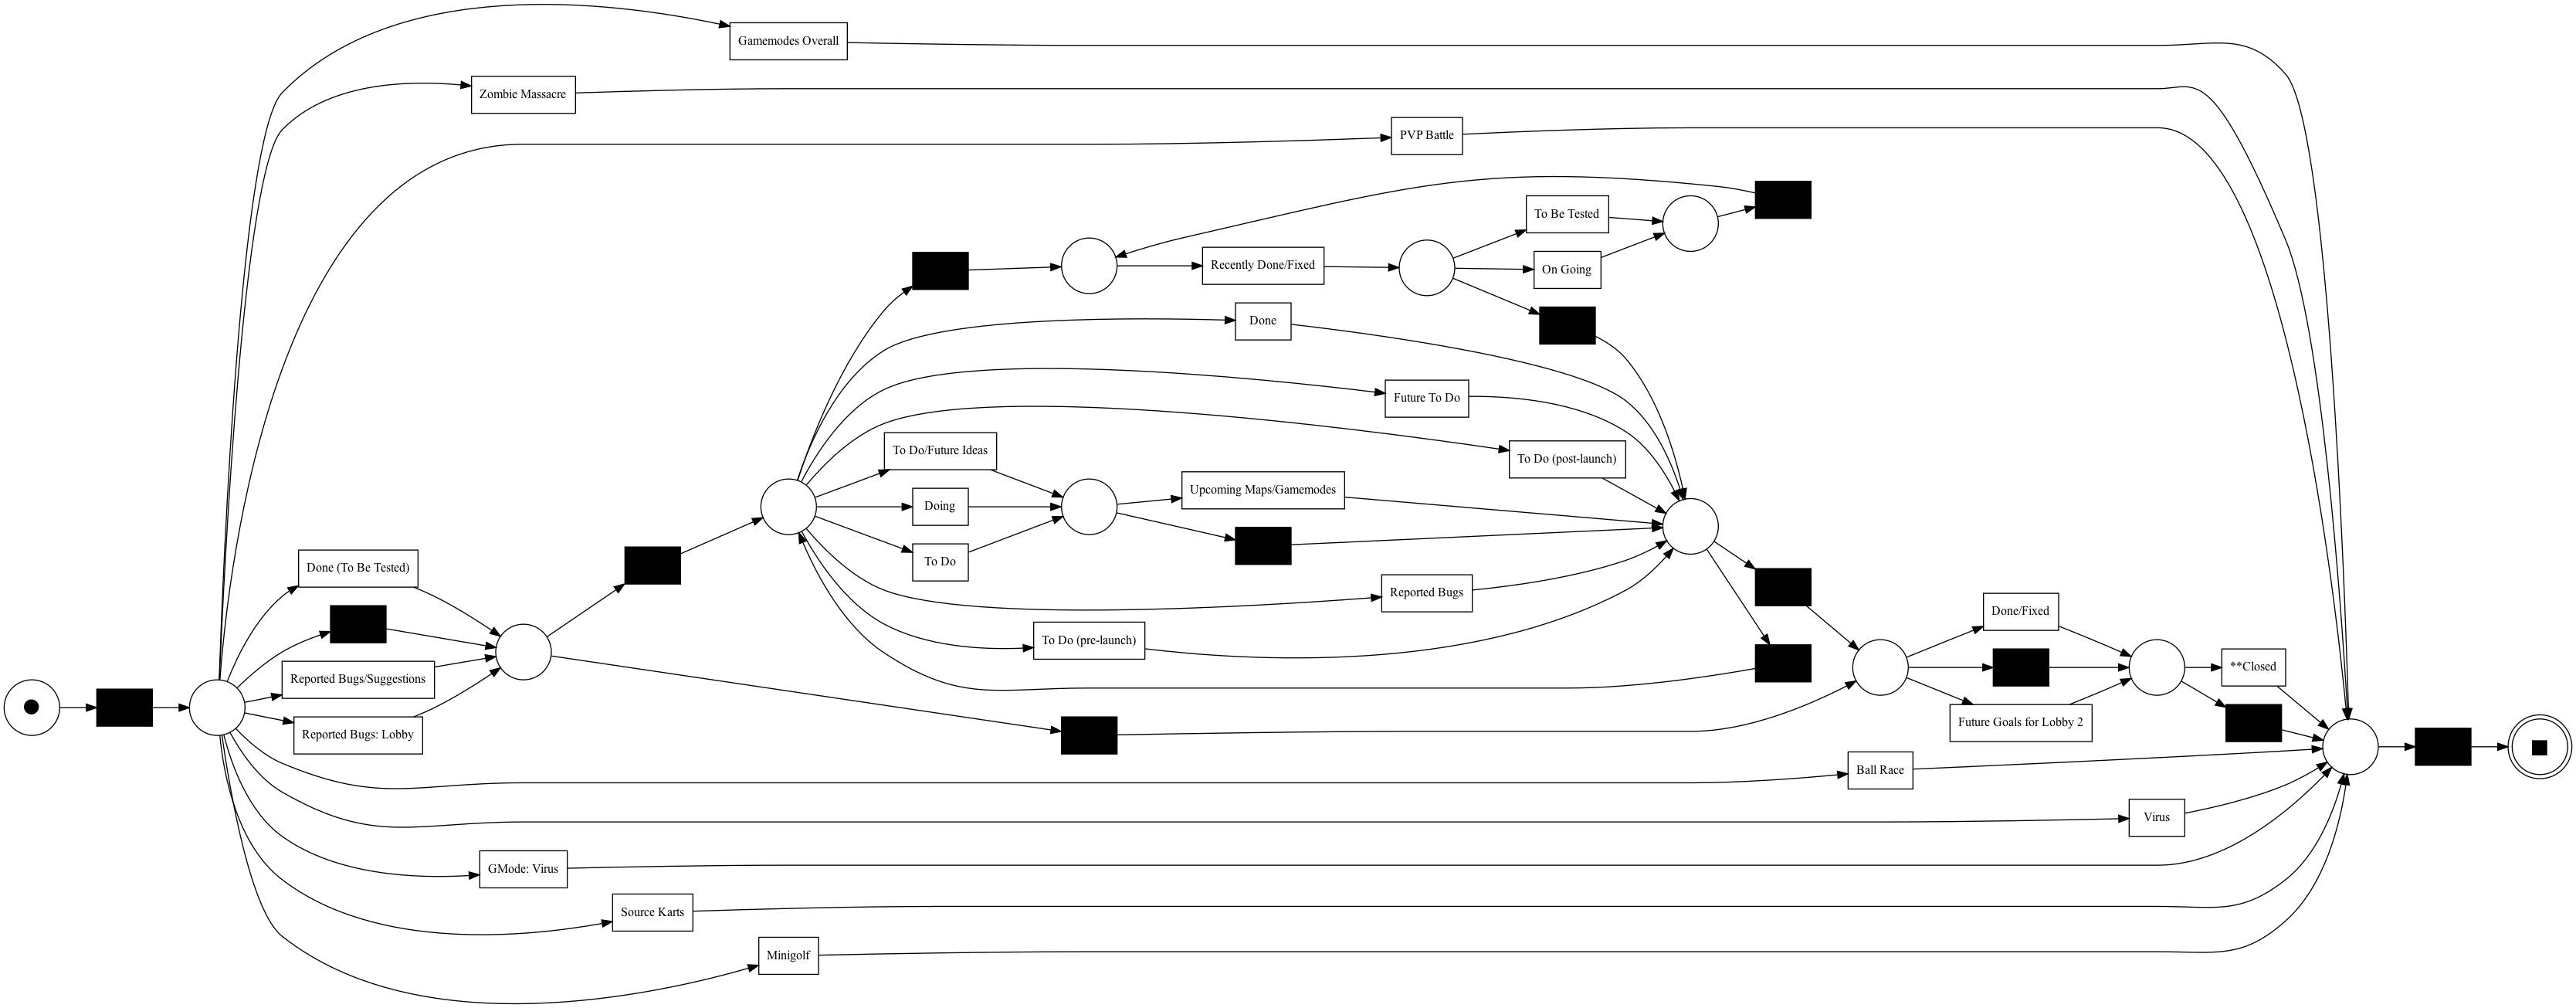

In [281]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.visualization.petri_net import visualizer as pn_visualizer

# process discovery algorithm
tree = inductive_miner.apply_tree(filtered_log)

# display process tree
gviz = pt_visualizer.apply(tree)
pt_visualizer.view(gviz)

# display petri net
net, initial_marking, final_marking = pt_converter.apply(tree, variant=pt_converter.Variants.TO_PETRI_NET)
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

# Resto

In [ ]:
df['data.list.name'].value_counts()

Stuff                                                     540
Soulshatters Ideas                                        276
Soulshatters Reworks (Community Trello)                   238
UT Fighting Ideas                                         147
UT Fighting Reworks                                       139
Soulshatters Reworks Page 2 (Official Version Reworks)     97
UCD Movesets                                               91
Soulshatters Reworks                                       68
Glitchtale Battle of Souls Ideas                           46
Soulshatters Ideas Page 2                                  38
Glitchtale Battle of Souls Reworks                         28
Soulshatters Self Insert Moveset                           27
GTBOS Ideas Page 2                                         26
Soulshatters Ideas Page 2 (Gamepasses)                     24
Undertale Judgement Day                                    22
GTBOS Ideas: Inverted Traits                               20
DT Trio 

In [ ]:
df['idMemberCreator'].value_counts().describe()

count       24.000000
mean       587.833333
std       2795.804087
min          1.000000
25%          1.000000
50%          2.500000
75%          9.500000
max      13711.000000
Name: idMemberCreator, dtype: float64

In [ ]:
df.groupby('type')['idMemberCreator'].nunique()

type
addAttachmentToCard         2
addChecklistToCard          1
addMemberToBoard            1
addMemberToCard             2
commentCard                 4
copyBoard                   1
copyCard                    2
copyCommentCard             1
createCard                  3
createList                  1
deleteAttachmentFromCard    1
deleteCard                  1
makeAdminOfBoard            2
makeNormalMemberOfBoard     1
moveCardFromBoard           1
moveCardToBoard             1
moveListFromBoard           1
removeMemberFromCard        1
updateBoard                 1
updateCard                  5
updateList                  1
Name: idMemberCreator, dtype: int64

In [ ]:
df['data.card.id'].nunique()

998

In [ ]:
df['type'].value_counts()

commentCard                   21142
updateCard                     3266
updateCheckItemStateOnCard     1364
createCard                      830
addChecklistToCard              287
updateChecklist                 209
updateList                      162
deleteCard                      145
addMemberToCard                 109
addAttachmentToCard              97
removeChecklistFromCard          69
createList                       50
deleteAttachmentFromCard         49
updateBoard                      31
addMemberToBoard                 21
removeMemberFromCard             13
copyCard                         11
convertToCardFromCheckItem       11
createBoard                       1
Name: type, dtype: int64

In [ ]:
comb = df['data.listBefore.name'] + df['data.listAfter.name']

In [ ]:
comb.value_counts()

Current GoalsVersion .28                      33
Current GoalsVersion .44                      32
yname Todoyname Done                          28
Current GoalsVersion .46                      27
Next UpdateVersion .52                        21
                                              ..
Galaxy Devs Development BoardDiscussion        1
DiscussionFuture Goals (Subject to Change)     1
Next UpdateDiscussion                          1
DiscussionFuture Goals                         1
Future GoalsVersion .41                        1
Length: 88, dtype: int64

In [ ]:
df['data.old.name'].count()

5812

In [ ]:
df.groupby('data.card.id')['type'].value_counts()

data.card.id              type           
56002281e63f48b6c2642b0b  createCard         1
56002285c54eb4f654b11859  createCard         1
5600228fe6d280c1ba1c5518  createCard         1
5600229cd8417540b8154382  createCard         1
560022a3a1444f94c2deef74  createCard         1
                                            ..
620943fd2596fe66a8df6ff3  addMemberToCard    1
                          createCard         1
620d48adaf1011873cf57dcd  updateCard         2
                          addMemberToCard    1
                          createCard         1
Name: type, Length: 2632, dtype: int64

In [ ]:
df[df['type']=='createCard'].groupby('data.list.name')['data.card.id'].count()

data.list.name
Backlog                                                                  3
Cache not always purged for campaign when deleting entire campaign       1
Done                                                                    48
Focus                                                                  375
Inbox                                                                   86
Ready for Publishing                                                   111
Started                                                               1052
Testing                                                                356
To Be Published                                                         34
To Do                                                                    8
Name: data.card.id, dtype: int64

In [ ]:
df[df['data.card.id']=='5a6b119f0fdae8c8b2001d4c']

,Unnamed: 0,id,idMemberCreator,appCreator,type,date,data.card.desc,data.card.id,data.card.name,data.card.idShort,...,limits.reactions.uniquePerAction.disableAt,limits.reactions.uniquePerAction.warnAt,data.attachment.id,data.attachment.name,data.attachment.url,data.attachment.previewUrl,data.attachment.previewUrl2x,data.boardSource.id,data.boardSource.prefs.isTemplate,data.boardSource.templateCategory


In [ ]:
min(df['date']), max(df['date'])

('2015-09-21T15:28:44.622Z', '2022-02-17T13:52:12.992Z')